# Analyzing And Reducing Building Energy Usage In NYC
------

## Contents

__[1. Introduction](#first-bullet)__

__[2. Initial Cleaning And Analysis](#second-bullet)__

__[3. Analysis Of Multifamily Housing ](#third-bullet)__

__[4. Recommendations And Conclusion ](#fourth-bullet)__


--------------

## Introduction <a class="anchor" id="first-bullet"></a>
-------------
	
The NYC Benchmarking Law requires owners of large buildings to annually measure their energy and water consumption in a process called benchmarking. The law standardizes this process by requiring building owners to enter their annual energy and water use in the U.S. Environmental Protection Agency's (EPA) online tool, ENERGY STAR Portfolio Manager® and use the tool to submit data to the City. This data gives building owners about a building's energy and water consumption compared to similar buildings, and tracks progress year over year to help in energy efficiency planning.  In this blog post we will analyze how buildings in New York City use energy and water and make recommendations on how to improve their performance. The source code for this project can be found <a href="https://github.com/mdh266/NYCBuildingEnergyUse">here</a>.


----------
## Dataset
----------

Benchmarking data is disclosed publicly and can be found <a href="http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml">here</a>.  I analyzed the 2016 data and my summary of the findings and recommendations for reducing energy consumption in New York City buildings are discussed below.  

The 2016 data is very messy and a lot of cleaning was necessary to do analysis on it.  There are about 13,223 buildings recorded in this dataset and many of them have missing data values. The cleaning process was made more difficult because the data was stored as strings with multiple non-numeric values which made converting the data to its proper type a more involved process.  Let's dive into that right now.

--------------------------
## Initial Cleaning And Analysis <a class="anchor" id="second-bullet"></a>
-------------------------
As mentioned before this data was rather messy, I created functions to clean the data and also a plotting function that rather long.  I kept these functions in seperate files <code>Cleaning_Functions.py</code> and <code>Plotting_Functions.py</code> respecively so as to not clutter the post.  We import these functions along with other libraries and read in the data file below:

In [1]:
## import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from Cleaning_Functions import *
from Plotting_Functions import *

df_2016 = pd.read_excel("nyc_benchmarking_disclosure_data_reported_in_2016.xlsx")

There are about 13,233 buildings with different types of energy usage, emissions and other information.  I'll drop a bunch of these features since there are so many and only keep the following,

- Reported NYC Building Identification Numbers : [BINs]
- NYC Borough, Block and Lot : [BBL]
- Street Number : [Street_Number]
- Street Name : [Street_Name]
- Zip Code : [Zip_Code]
- Borough : [Borough]
- Year Built : [Year_Built]
- DOF Benchmarking Status :[Benchmarking_Status]
- Site EUI (kBtu/ft$^{2}$) : [Site_Eui]
- Natural Gas Use [N(kBtu) : [Nat_Gas]
- Electricity Use (kBtu):  [Elec_Use]
- Total GHG Emissions (Metric Tons CO2e) : [GHG]
- ENERGY STAR Score : [Energy_Star]
- Water Use (All Water Sources) (kgal) : [Water_Use]
- Nautral Gas Use Intensity (kBtu/ft$^{2}$) : [NGI]
- Electricty Use Intensity (kBtu/ft$^{2}$) : [EI]
- Water Use Intensity (kga/ft$^2$) : [WI]

Where the terms in the square brackets are the column names in the dataframe. I wrote a basic function to clean the data feature names and drop the columns called <code>initial_clean()</code>. We call it on our data and then get some basic statistics about the data:

In [2]:
df_2016_2 = initial_clean(df_2016)
temp_cols_to_drop = ['BBL','Street_Number','Zip_Code']

df_2016_2.drop(temp_cols_to_drop, axis=1)\
         .describe()

,Occupancy,Energy_Star,Site_EUI,Nat_Gas,Elec_Use,GHG,Water_Use,NGI,EI,WI
count,11531.000000,9535.000000,11439.000000,1.008700e+04,1.142500e+04,1.147800e+04,7.265000e+03,9870.000000,11206.000000,7261.000000
mean,98.987512,57.735711,525.733377,2.520461e+07,8.201496e+06,6.952577e+03,2.579751e+04,137.705639,54.266179,0.161268
std,6.941736,30.143817,10120.105154,1.194068e+09,1.214643e+08,1.692231e+05,5.860239e+05,7512.527146,1210.530111,2.053453
min,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,100.000000,34.000000,65.300000,8.915501e+05,1.045702e+06,3.420250e+02,2.661700e+03,7.324853,13.682696,0.028523
50%,100.000000,63.000000,82.400000,4.067600e+06,1.885996e+06,5.198000e+02,4.745600e+03,46.268145,18.482229,0.046098
75%,100.000000,83.000000,103.000000,6.919267e+06,4.513704e+06,9.394500e+02,8.057900e+03,68.036285,30.716894,0.073287
max,100.000000,100.000000,801504.700000,1.101676e+11,1.047620e+10,1.501468e+07,4.385740e+07,737791.764249,84461.681703,98.340480


The above is only a summary of the numrical data in the dataframe. Just looking at the <code>count</code> column we can immediately see that there are a lot of missing valus in this data. This tells me that this data will be rather messy with many columns having NaNs or missing values.

It also looks like there is a lot of variation within this dataset.  Just looking at the <code>Site_EUI</code> statistic, the 75th percentile is is 103 (kBtu/ft²), but the max is 801,504.7 (kBtu/ft²).  This probably due to the number of different types of buildings in the city. 


The next thing I would like to see is how many of the buildings in NYC are passing the Benchmarking Submission Status:

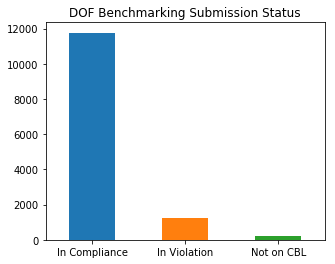

In [3]:
plt.figure(figsize=(5,4))
df_2016_2['Benchmarking_Status'].value_counts()\
                                .plot(kind='bar')
plt.xticks(rotation=0)
plt.title('DOF Benchmarking Submission Status')

Most buildings are in compliance with the Department of Finance Benchmarking standards. Let's take a look at the violators:

In [4]:
Violators = df_2016_2[df_2016_2.Benchmarking_Status == 'In Violation']
Violators['Zip_Code'] = Violators['Zip_Code'].astype(int)

/Users/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


There's not much we can learn from this, if we can look to see if certain zip codes have more buildings in violation.  We group by the zipcodes and count them:

In [5]:
zips_df = Violators.groupby('Zip_Code')['Zip_Code'].size()\
                   .reset_index(name='counts')

In [6]:
import geopandas as gpd

In [7]:
gdf = gpd.read_file("nyc-zip-code-tabulation-areas-polygons.geojson")
gdf["postalCode"] = gdf["postalCode"].astype(int)

In [8]:
gdf= gdf.merge(zips_df, how="left", left_on="postalCode", right_on="Zip_Code")\
         .drop(["OBJECTID","Zip_Code"], axis=1)\
         .fillna(0)


In [210]:
gdf["counts"] = gdf["counts"].astype(int)

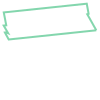

In [9]:
gdf['geometry'][0].exterior

In [10]:
source = convert_GeoPandas_to_Bokeh_format(gdf)

ColumnDataSource(id='20d1ae7d-e64d-455d-ad31-3b8e2a4e3f82', ...)

In [12]:
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import (
    Range1d,
    GeoJSONDataSource,
    HoverTool,
    LinearColorMapper,
    GMapPlot, GMapOptions, ColumnDataSource, 
    Circle, DataRange1d, PanTool, WheelZoomTool, BoxSelectTool,
    LogColorMapper,ColorBar,LogTicker
)
TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save" 
from bokeh.io import output_file, output_notebook, show
output_notebook()
from bokeh.palettes import Plasma6 as palette
palette.reverse()
color_mapper = LogColorMapper(palette=palette, low=0.0, high=zips_df["counts"].max())


Loading BokehJS ...

In [13]:
fig = figure(title="Number Of Violators By Zipcode", 
                tools=TOOLS,
                x_axis_location=None, 
                y_axis_location=None)  

fig.grid.grid_line_color = None

fig.patches('x', 'y', 
            source=source, 
            fill_color={'field':'counts', 'transform': color_mapper},
            fill_alpha=0.7, line_color="white", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, #ticker=LogTicker(),
                     label_standoff=5, border_line_color=None, location=(0,0))

hover = fig.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Neighborhood", "@PO_NAME"),
    ("Zip Code", "@postalCode"),
    ("Num. Of Violations", "@counts"),
    ("(Long, Lat)", "($x, $y)")
]


fig.add_layout(color_bar, 'left')
show(fig)

Let's see the distributution of all buildings that are in different ranges of the <code>Energy Star</code> ratings:

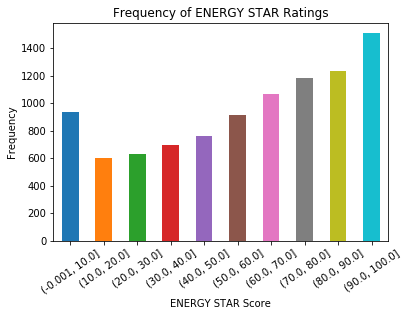

In [14]:
bins = [0,10,20,30,40,50,60,70,80,90,100]

df_2016['ENERGY STAR Score'].value_counts(bins=bins)\
                            .sort_index()\
                            .plot(kind='bar',
                                  rot=35,
                                  title='Frequency of ENERGY STAR Ratings'
                                  )
plt.ylabel('Frequency')
plt.xlabel('ENERGY STAR Score')

We can see that the majority are within the 50-100 range, but a almost 1000 buildings have scores inbetween 0 and 10. Let's take a look at the distribution of building types.  We will just take the top 10 most common building types for now..

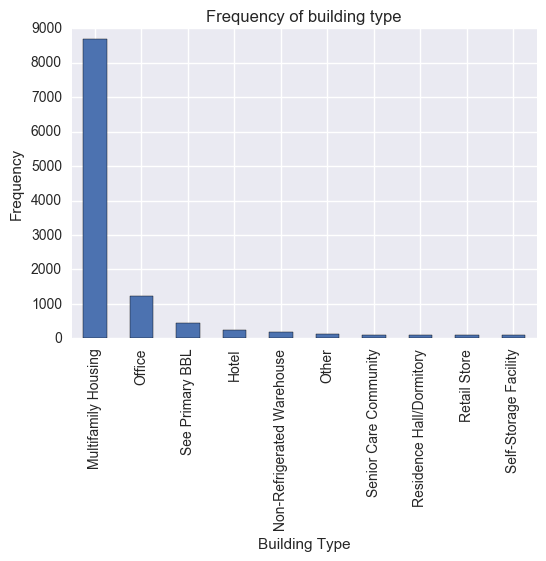

In [8]:
df_2016_2['Property_Type'].value_counts()\
                          .head(10)\
                          .plot(kind='bar',
                                title='Frequency of building type')
plt.xlabel('Building Type')
plt.ylabel('Frequency')

The most common buildings in NYC are multifamily housing, then offices, then other, hotels and somewhat suprisingly non-refrigerated warehouse space.  I would have thought that there would be more schools and retail spaces than warehouses or dormitorites in New York City, but I don't know what the <code>Primaty BBL</code> listing is.


Let's look at the Energy Star ratings of buildings across different building types, but first how many different building types are there?  We can find this out,

In [9]:
print "Number of building types are: " + str(len(df_2016_2['Property_Type'].unique()))

Number of building types are: 54


This is too many building types to visualize the Energy Star Score (<code>Energy_Star</code>) of each, we'll just look at just 5 building types, lumping the 54 into the categories into either:
- Residential
- Office
- Retail
- Storage
- Other

I built a function to group the buildings into the 5 types above called <code>clean_property_type(...)</code> and we use it below to transform the Pandas Series:

In [10]:
Property_Type = df_2016_2.copy()
Property_Type['Property_Type']=Property_Type['Property_Type'].apply(group_property_types)

Now we can look at the  <code>Energy_Star</code> (score) of each of the buildings types:

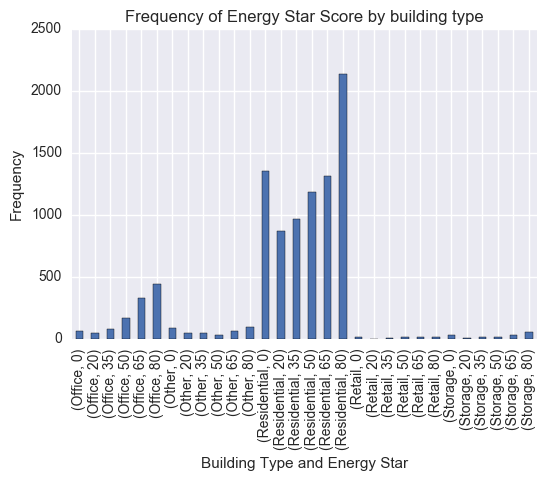

In [11]:
bins2 = [0,20,35,50,65,80,100]

Energy_Star_Scores = Property_Type.groupby(['Property_Type'])['Energy_Star']

Energy_Star_Scores.value_counts(bins=bins2)\
                  .sort_index()\
                  .plot(kind='bar',
                        title='Frequency of Energy Star Score by building type')
        
plt.xlabel('Building Type and Energy Star')
plt.ylabel('Frequency')

Overall it looks like residential buildings have a lot more proportion of low Energy Star Scoring buildings when compared to office buildings. This is probably because there are much more older residential buildings than office spaces in New York City. We'll look at the distribution of the years in which builings of just properties of type: 'Multifamily Housing' and 'Office' were built:

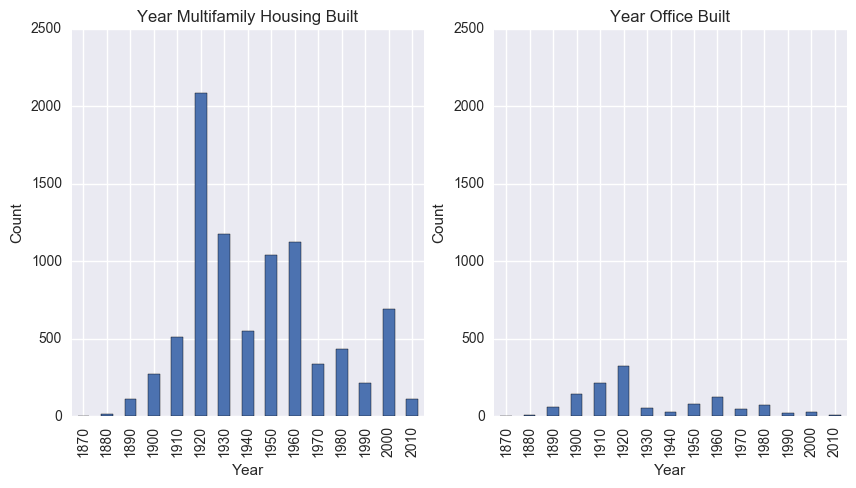

In [12]:
plot_years_built(df_2016_2)

It seems like it's the opposite of what I thought, but the number of residential buildings is much higher and the majority were built right before and right after the war as well as the the 2000s.  The same is true about offices without the uptick in the early 2000s.

Let's just focus on the multifamily housing and see what we can find out about them since they may offer the best return on investment in terms of improving energy efficiency.

-------------------------------------
## Analysis Of Multifamily Housing <a class="anchor" id="third-bullet"></a>
--------------------------------------

First let's look at the summary statistics of just the mulitfamily housing:

In [13]:
Multifamily_Buildings = df_2016_2[df_2016_2['Property_Type'] == 'Multifamily Housing']

Multifamily_Buildings.drop(temp_cols_to_drop,axis=1)
                     .describe()

,Occupancy,Energy_Star,Site_EUI,Nat_Gas,Elec_Use,GHG,Water_Use,NGI,EI,WI
count,8699.000000,7513.000000,8654.000000,7.914000e+03,8.643000e+03,8.669000e+03,5.499000e+03,7704.000000,8432.000000,5497.000000
mean,99.616623,56.629842,405.938456,2.991518e+07,4.536019e+06,4.093800e+03,1.193724e+04,164.160356,31.980654,0.107960
std,3.358280,30.477155,9520.852245,1.347821e+09,5.199372e+07,8.535570e+04,8.786550e+04,8502.255602,495.657557,0.905276
min,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,100.000000,32.000000,67.900000,1.249754e+06,9.817544e+05,3.419000e+02,3.146700e+03,10.052411,13.248499,0.035663
50%,100.000000,61.000000,82.900000,4.429401e+06,1.539532e+06,4.928000e+02,5.100200e+03,52.311449,16.720334,0.051203
75%,100.000000,83.000000,101.100000,7.227774e+06,3.000909e+06,8.164000e+02,8.046100e+03,70.215899,22.614394,0.077178
max,100.000000,100.000000,801504.700000,1.101676e+11,3.729784e+09,5.860677e+06,3.638813e+06,737791.764249,35863.305400,52.143200


We can see again, large variations in the energy data, with most of it being between 0 and some fixed number and then atleast one outlier.  Comparing multifamily housing to all buildings in NYC (previous table) we can see that all of the mean value and variation of the energy, water and emission rates are lower for multifamily housing buildings than overall buildings in NYC.


Now let's take a look at how the performance features relate to by plotting the correlation matrix. But first since we have so much missing data, let's take at the total number of multifamily buildings and the number of multifamily buildings without missing data.

In [14]:
cols_to_drop = ['BBL','BINs','Street_Number','Street_Name',
                'Zip_Code', 'Borough','Benchmarking_Status', 
                'Property_Type', 'Occupancy']

X = Multifamily_Buildings.drop(cols_to_drop,axis=1)
X_clean = X.dropna()

print "Total Multifamily Buildings: " + str(X.shape[0])
print "Total Multifamily Buildings without missing data: " + str(X_clean.shape[0])

Total Multifamily Buildings: 8699
Total Multifamily Buildings without missing data: 4407


About half of the multifamily buildings have missing data, that's significant.  Let's plot the correlation matrix to see how correlated are features are on the all the multifamily buildings.  We note that we first have to normalize the data.

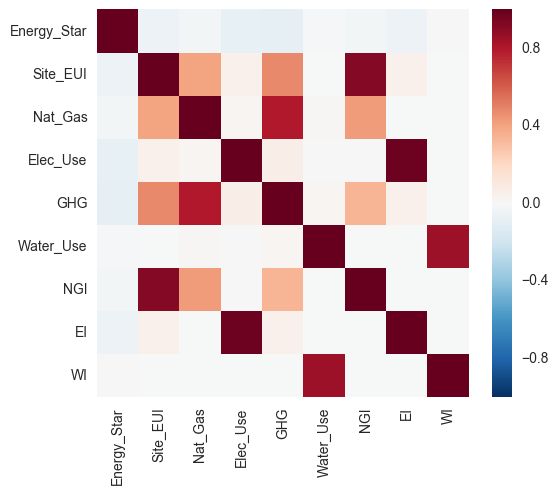

In [15]:
fig, ax = plt.subplots(figsize=(6,5))  
X_s = (X - X.mean())/X.std()
sns.heatmap(X_s.corr())

We can see that natural gas usage is fairly strongly correlated to green house emission rates, which makes sense.  We can also see that Energy Usage Intensity is strongly correlated with Natural Gas Intensity.  What doesn't make sense is that the energy star score is weakly correlated to any of the measures of energy or water usage.  This is because the a higher energy star score is supposed to reflect more efficient use of energy and water.

We can see how the results change when we only use multifamily building data that do not have missing values:

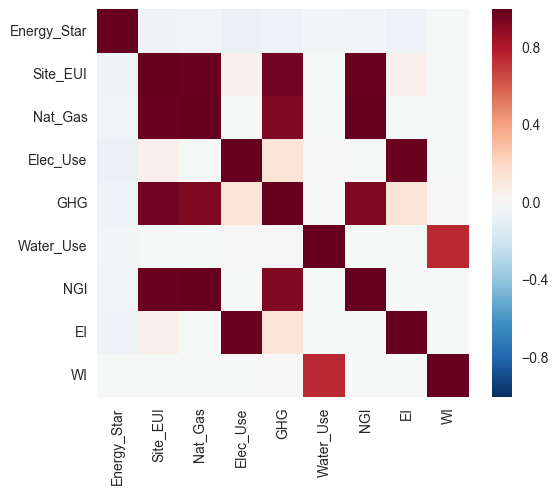

In [16]:
fig, ax = plt.subplots(figsize=(6,5))
X_s_clean = (X_clean - X_clean.mean())/X_clean.std()
sns.heatmap(X_s_clean.corr())

The previously mentioned correlations are now stronger, but still too weak a correlation between energy star score and energy or water usage for my liking.  Let's look at the scatter plot of natural gas usage and energy usage intensity:

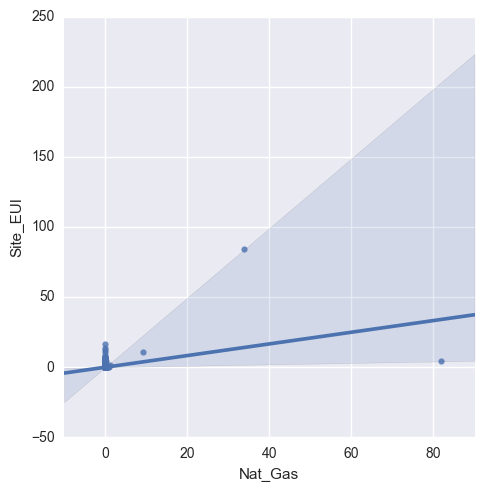

In [17]:
sns.pairplot(X_s, 
             x_vars='Nat_Gas',
             y_vars='Site_EUI',
             kind='reg',
             size=5,dropna=True)

We can see that are some signficant outliers in our data.  Experimenting with different values i was able to remove them and a clearer relationship between the natural gas usage and EUI:

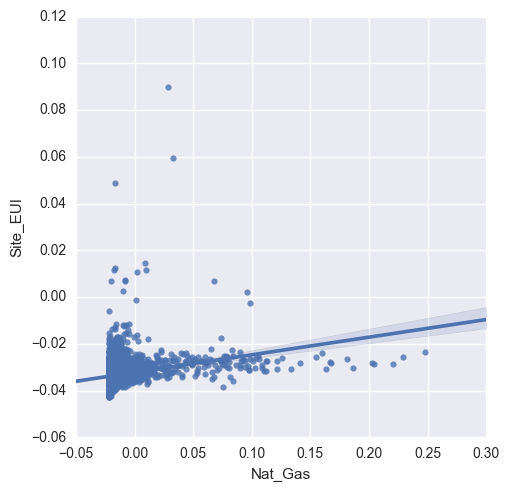

In [18]:
X_s_Nat_Gas = X_s[X_s.Nat_Gas < 0.4]
X_s_Nat_Gas = X_s_Nat_Gas[X_s_Nat_Gas.Site_EUI < 0.2]

sns.pairplot(X_s_Nat_Gas, 
             x_vars='Nat_Gas',
             y_vars='Site_EUI',
             kind='reg',
             size=5,
             dropna=True)

I did the same for electricity usage and EUI:

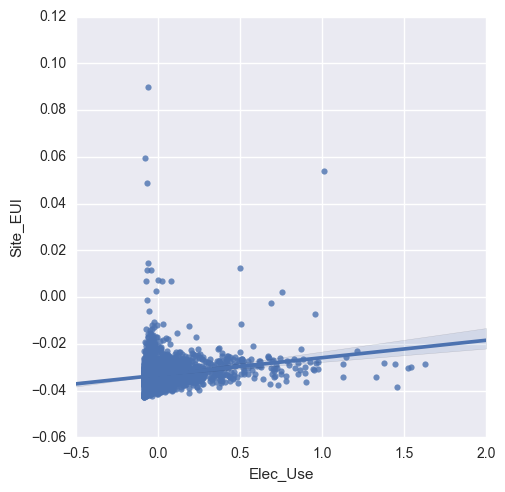

In [19]:
X_s_Elec_Use = X_s[X_s.Elec_Use < 2]
X_s_Elec_Use = X_s_Elec_Use[X_s_Elec_Use.Site_EUI < 0.1]

sns.pairplot(X_s_Elec_Use, 
             x_vars='Elec_Use', 
             y_vars='Site_EUI', 
             kind='reg', 
             size=5,
             dropna=True)

And did the same for water usage and EUI.  While it might not seem water and energy usage could be correlated with energy usage intensity, often water is used for heating and cooling in buildings:

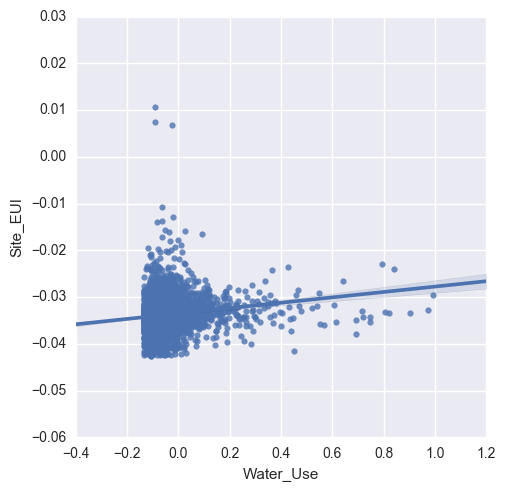

In [20]:
X_s_Water_Use = X_s[X_s.Water_Use < 1]
X_s_Water_Use = X_s_Water_Use[X_s_Water_Use.Site_EUI < 0.04]
sns.pairplot(X_s_Water_Use,
             x_vars='Water_Use', 
             y_vars='Site_EUI',
             kind='reg',
             size=5, 
             dropna=True)

Now we make a dataframe that has all the removed outliers and we plot the EUI vs. energy and water usage:

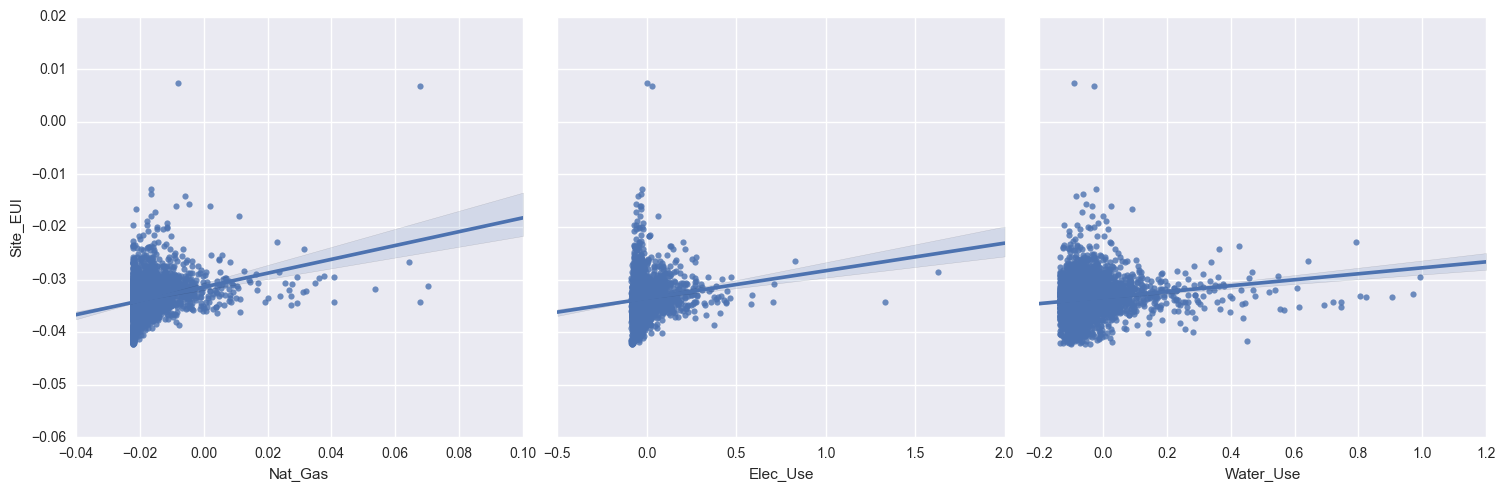

In [21]:
X_outliers_removed = X_s[X_s.Nat_Gas < 0.4]
X_outliers_removed = X_outliers_removed[X_outliers_removed.Elec_Use < 2]
X_outliers_removed = X_outliers_removed[X_outliers_removed.Site_EUI < 0.08]
X_outliers_removed = X_outliers_removed[X_outliers_removed.Water_Use < 1]

sns.pairplot(X_outliers_removed, 
             x_vars=['Nat_Gas','Elec_Use','Water_Use'], 
             y_vars='Site_EUI', 
             kind = 'reg',
             size=5, 
             dropna=True)

The relationship isn't quite as strong as compared to the EUI vs. energy intensity and water intensity below:

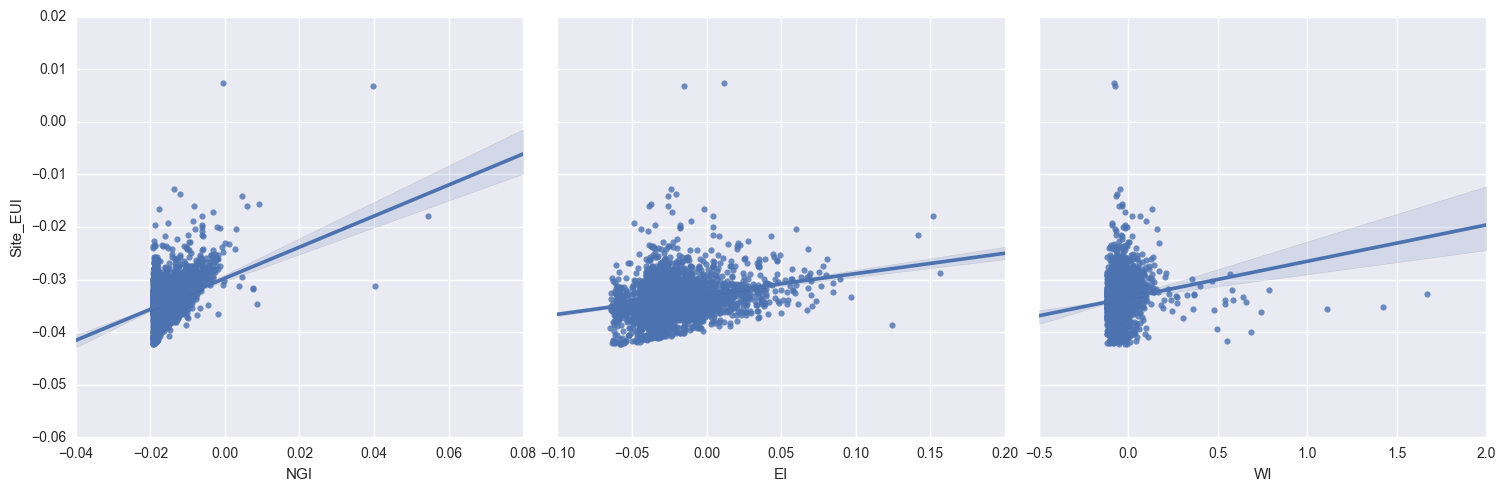

In [22]:
sns.pairplot(X_outliers_removed, 
             x_vars=['NGI','EI','WI'], 
             y_vars='Site_EUI', 
             kind = 'reg',
             size=5, 
             dropna=True)

It look's like EUI is very strongly correlated to the natural gas usage intensity when comparedd to electricity usage.  The relationship between EUI and water usage intensity is a little harder to ascertain.  

We can also see from the plot below that the site EUI wasnt very correlated to the year that the buildings were constructed, probably because so many were built around the same time period.

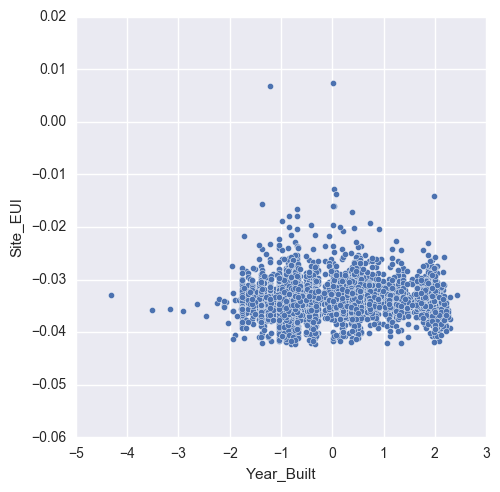

In [23]:
sns.pairplot(X_outliers_removed, 
             x_vars='Year_Built', 
             y_vars='Site_EUI', 
             size=5, 
             dropna=True)

Now that we have removed some outliers and have multifamily buildings that have very similar characteristis we can visualize the correlation matrix to try to gleam some insights into improving these building energy efficiency.

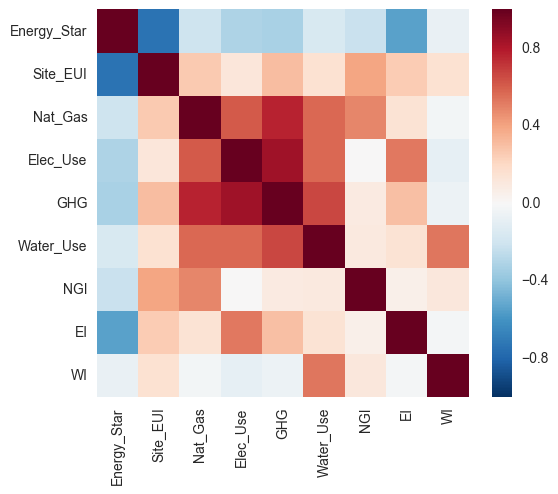

In [24]:
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(X_outliers_removed.corr())

This is a much more belivable correlation matrix than the previous two.  We can see that the Energy Star score is very negatively correlated with enery usage intensity, which make sense as the energy star score is a measure of energy efficiceny of the building.  


We should note that the number of buildings in this case is,

In [26]:
print "Total Multifamily Buildings in reduced data: " + str(X_outliers_removed.shape[0])

Total Multifamily Buildings in reduced data: 4967


While our procedure does not have substantially more buildings then the case when we drop all the buildings with any missing data, the data on the buildings in this case is much more informative.  

We can see that the Energy Star score is negatively correlated with enery usage intensity. This makes sense as the energy star score is a measure of energy efficiceny of the building.  The energy usage intensity has a strong positive correlation to the natural gas usage intensity.  We can see that natural gas usage intensity and electricity usage intensity are uncorrlated.  This implies we could replace one with the other.  Therefore reducing natural gas consumption or replacing it with electricity could be the best answer to reducing energy usage intensity.  It should also be noted that year the residence was built did not have any correlation with energy usage intensity. This is probably due to the fact that the majority of residential buildings in New York City were built in a similar time period and before energy efficiency was a priority.

--------------
## Recommendations And Conclusion <a class="anchor" id="fourth-bullet"></a>
--------------

Since natural gas usage intensity is most highly correlated with energy usage intensity reducing it could improve building energy efficiency.  Some ways to reduce natural gas consumption include:

- Investing in more efficient heating and cooling services or slightly reducing the usage of either heating or cooling during the day when most people are not home. This is especially important in large buildings as HVAC systems have a larger volume of air to heat/cool.


- Another option is to reuse waste heat, such as reusing the vented air from electric clothes dryers, however, filtering and the air will be necessary and could alter the cost effectiveness of this approach.


- Replacing gas powered appliances such as stoves with more efficient electric ones is another option.  However, the source of electric power should also be considered to weigh the overall energy efficiency and enviromental impact.


- Another option is to replace gas powered water heaters by solar powered water heaters. While solar powered water heaters are not as cost effective in moderate climates, the presence of numerous roof top water tanks on New York City buildings may help make this option more financially competitive.  At the very least, it suggests that having roof top water tanks for solar powered water heaters is structurally possible, where as with individual houses this may not be the feasible.


- In addition, buying energy efficient refrigerators and dryers is also important as these are two of the largest energy consumers in ones home.


With more time I would have like to look into more of the features/indicators of peformance of buildings and their affact on energy efficiency.  I also would have liked to look at the historical data of each building and identify which buildings have been improving and which have not. I would have also like to have mapped out the different properties to see if there are areas or property owners that have particular issues with energy usage intensity or compliance with the Department Of Finance Benchmarking. I think this one be useful in helping to have a more focused approach to finding buildings with the highest ROI on energy efficiency investments.